HELLO
{0: 458396, 1: 459495, 2: 333149}


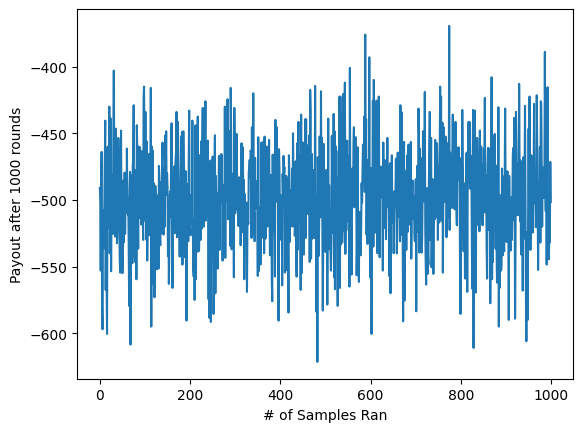

Average payout after 1000 rounds is -499.1995


In [1]:
# from blackjackenv import BlackjackEnv

from blackjackddoriginenv import BlackjackEnv 
import matplotlib.pyplot as plt
# env = BlackjackEnv()

# observation, info = env.reset(seed=42)
# for _ in range(100):
#     action = env.action_space.sample()
#     observation, reward, terminated, truncated, info = env.step(action)

#     if terminated or truncated:
#         observation, info = env.reset()
# env.close()


# env.reset(seed=42)



KEY = {0: 'STAND', 1:'HIT', 2:'DOUBLE DOWN'}
env = BlackjackEnv()
env._reset()

num_episodes = 1000 # num of episodes the simulation will run
num_rounds = 1000 # num of rounds/hands played per episode

# PERCENTAGE OF ACTIONS TAKEN
ACTIONSD = {0: 0, 1:0, 2:0}

average_payouts = []

for sample in range(num_episodes):
    round = 1
    total_payout = 0 # to store total payout over 'num_rounds'
    
    while round <= num_rounds:
        obs1, payout1, is_done1, ddown1 = env._get_obs()

        action = env.action_space.sample()  # take random action 
        
        while action == 2 and not ddown1:
            action = env.action_space.sample()

        ACTIONSD[action] += 1

        
        obs, payout, is_done, info, ddown  = env._step(action)
#         if action == 2:
#             continue
#             print('ACTION: ' + str(action))
#         print('OBS1: ' + str((obs1, payout1, is_done1, ddown1)))

#             print('OBS2: ' + str(obs))
#             print('PAYOUT: ' + str(payout))http://localhost:8888/notebooks/demo1.ipynb#
#         print('ID_DONE: ' + str(is_done))
#         print('INFO: ' + str(info))

        total_payout += payout
        if is_done:
            env._reset() # Environment deals new cards to player and dealer
            round += 1
    average_payouts.append(total_payout)

print(ACTIONSD)

plt.plot(average_payouts)                
plt.xlabel('# of Samples Ran')
plt.ylabel('Payout after ' + str(num_rounds) + ' rounds')
plt.show()     
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/num_episodes))


In [2]:
#### BASIC STRATEGY #####
def basic_strategy(player_hand, dealer_up_card):
    """
    2D Arrays Storing Actions- Rows represent player hand, and column represents dealer's up card
    Action Hard- actions appropriate when player has a hard hand (no aces)
    Action Soft- actions appropriate when player has a soft hand (at least one ace)
    """
    actionsHard = [[1]*10]*7 # 2 to 8
    actionsHard.append([1]*2 + [2]*4 + [1]*4) #9
    actionsHard.append([1]*1 + [2]*8 + [1]*1) #10
    actionsHard.append([1]*1 + [2]*9) #11
    actionsHard.append([1]*3 + [0]*3 + [1]*4) #12
    actionsHard.extend([[1]*1 + [0]*5 + [1]*4]*4) #13-16
    actionsHard.extend([[0]*10]*5) #17-21
    
    actionsSoft = [[2]*10] # A,A
    actionsSoft.append([1]*4 + [2]*2 + [1]*4) # A,2
    actionsSoft.append([1]*4 + [2]*2 + [1]*4) #A,3
    actionsSoft.extend([[1]*3 + [2]*3 + [1]*4]*2) #A4, A5
    actionsSoft.append([1]*2 + [0]*4 + [1]*4) #A,6
    actionsSoft.append([1]*1 + [0]*1 + [2]*4 + [0]*2 + [1]*2) #A,7
    actionsSoft.extend([[0]*10]) #A,8
    actionsSoft.extend([[0]*10]) #A,9
    actionsSoft.extend([[0]*10]) #A,10
    
    player_sum = sum(player_hand)

    if 1 in player_hand and len(player_hand) == 2:
        return actionsSoft[player_sum-2][dealer_up_card-1]
    else:
        return actionsHard[player_sum-2][dealer_up_card-1]

# Make sure actions have been stored correctly mainly when dealer's upcard is A
assert (basic_strategy([5,10], 2)) == 0
assert (basic_strategy([1,4], 1)) == 1


HELLO
{0: 722418, 1: 639913, 2: 99040}


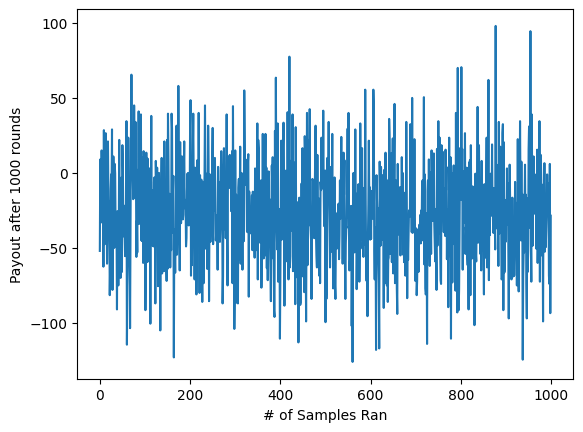

Average payout after 1000 rounds is -26.6265


In [3]:

################################################ SIMULATION ##########################
env = BlackjackEnv()
env._reset()


num_episodes = 1000 # num of episodes the simulation will run
num_rounds = 1000 # num of rounds/hands played per sample
total_payout = 0 # to store total payout

average_payouts = [] # store payout per episode

# PERCENTAGE OF ACTIONS TAKEN
ACTIONSD = {0: 0, 1:0, 2:0}

for x in range(num_episodes):
    round = 1
    round_payout = 0
    while round <= num_rounds:
        player_hand, dealer_up_card, is_done, ddown = (env._get_obs())
        
        # Take action based on normal strategy stored above
        action = basic_strategy(player_hand, dealer_up_card) 
        if ddown and action == 2:
            pass        
        elif not ddown and action == 2:
            action = 1
                
        ACTIONSD[action] += 1

        obs, payout, is_done, _, ddown= env._step(action)
        
        round_payout += payout
        total_payout += payout
        if is_done:
            env._reset() # Environment deals new cards to player and dealer
            round += 1
    average_payouts.append(round_payout)

print(ACTIONSD)
plt.plot(average_payouts)                
plt.xlabel('# of Samples Ran')
plt.ylabel('Payout after ' + str(num_rounds) + ' rounds')
plt.show()     
print ("Average payout after {} rounds is {}".format(num_rounds,sum(average_payouts)/num_episodes)   )

In [4]:
import random
import json
from sklearn.preprocessing import MinMaxScaler
class Agent():
    def __init__(self, env, epsilon=1.0, alpha=0.5, gamma=0.9, num_episodes_to_train=50000):
        self.env = env

        # Looks like n is number of valid actions from the souce code
        self.valid_actions = list(range(self.env.action_space.n))

        # Set parameters of the learning agent
        self.Q = dict()         # Q-table which will be a dictionary of tuples

        self.epsilon = epsilon   # Random exploration factor
        self.alpha = alpha       # Learning factor
        self.gamma = gamma       # Discount factor- closer to 1 learns well into distant future

        # epsilon will reduce linearly until it reaches 0 based on num_episodes_to_train
        # epsilon drops to 90% of its inital value in the first 30% of num_episodes_to_train
        # epsilon then drops to 10% of its initial value in the next 40% of num_episodes_to_train
        # epsilon finally becomes 0 in the final 30% of num_episodes_to_train
        self.num_episodes_to_train = num_episodes_to_train # Change epsilon each episode based on this
        self.small_decrement = (0.1 * epsilon) / (0.3 * num_episodes_to_train) # reduces epsilon slowly
        self.big_decrement = (0.8 * epsilon) / (0.4 * num_episodes_to_train) # reduces epilon faster

        self.num_episodes_to_train_left = num_episodes_to_train
        
        self.thompson_alpha = np.ones(self.env.action_space.n)
        self.thompson_beta = np.ones(self.env.action_space.n)
        
        self.action_values = np.zeros(self.env.action_space.n) 
        self.action_values += 1/3 
        self.temperature = 0.1

    def update_parameters(self,dynamic):
        """
        Update epsilon and alpha after each action
        Set them to 0 if not learning
        """
        
        if dynamic:
            
        
            if self.num_episodes_to_train_left > 0.8 * self.num_episodes_to_train:
                self.epsilon -= self.big_decrement 
            elif self.num_episodes_to_train_left > 0.6 * self.num_episodes_to_train:
                self.epsilon -= self.big_decrement 
            elif self.num_episodes_to_train_left > 0.4 * self.num_episodes_to_train:
                self.epsilon -= self.small_decrement
            elif self.num_episodes_to_train_left > 0.2 * self.num_episodes_to_train:
                self.epsilon -= self.small_decrement
            elif self.num_episodes_to_train_left > 0:
                self.epsilon -= self.small_decrement
            else:
                self.epsilon = 0.0
                self.alpha = 0.0
                
        

        self.num_episodes_to_train_left -= 1

    def create_Q_if_new_observation(self, observation):
        """
        Set intial Q values to 0.0 if observation not already in Q table
        """
        if observation not in self.Q:
            self.Q[observation] = dict((action, 0.0) for action in self.valid_actions)


    def get_maxQ(self, observation):
        """
        Called when the agent is asked to find the maximum Q-value of
        all actions based on the 'observation' the environment is in.
        """
        self.create_Q_if_new_observation(observation)
        return max(self.Q[observation].values())
    def get_boltzmann_action(self,observation, dynamic):
        
#         print(type(self.Q))
#         print(self.Q)


        if dynamic: 
        
            if self.num_episodes_to_train_left > 0.8 * self.num_episodes_to_train:
                self.temperature = 0.8 
            elif self.num_episodes_to_train_left > 0.6 * self.num_episodes_to_train:
                self.temperature = 0.6 
            elif self.num_episodes_to_train_left > 0.4 * self.num_episodes_to_train:
                self.temperature = 0.4 
            elif self.num_episodes_to_train_left > 0.2 * self.num_episodes_to_train:
                self.temperature = 0.2 

            else:
                self.temperature = 0.1 

            
        
        current_action_values = np.zeros(self.env.action_space.n) 

        for key,value in self.Q[observation].items():


#             if value != 0 : 

          current_action_values[key] = value
#             else:
#                 current_action_values[key] = 1e-10 


#         print(self.action_values)

        exp_probabilities = np.exp(current_action_values / self.temperature )
#         print( 'exp', exp_probabilities)
        probabilities = exp_probabilities / np.sum(exp_probabilities)

#         print( 'normoalization' , probabilities)
        probabilities[-1] = 1 - np.sum(probabilities[:-1])

#         if 1- np.sum(np.sum(probabilities[:-1])) < 1e-10 :
#             probabilities[-1] = 1e-10


#         print(probabilities)
        # choose actions according to the probabilities
        action = np.random.choice(range(self.env.action_space.n), p=probabilities)
            
        self.num_episodes_to_train_left -= 1
        
        return action 

    def update_thompson_sampling_action(self, reward,action,dynamic):
        
        

        if dynamic:
            
        
            if self.num_episodes_to_train_left > 0.8 * self.num_episodes_to_train:

                
                self.thompson_alpha[action] += reward
                if self.thompson_alpha[action] <= 0 :
                    self.thompson_alpha[action] = 1e-10 

                self.thompson_beta[action] += 1 - reward
                if self.thompson_beta[action] <= 0 :
                    self.thompson_beta[action] = 1e-10    
                
                
            elif self.num_episodes_to_train_left > 0.6 * self.num_episodes_to_train:
                
                
                self.thompson_alpha[action] += reward * 0.6 
                if self.thompson_alpha[action] <= 0 :
                    self.thompson_alpha[action] = 1e-10 

                self.thompson_beta[action] += (1 - reward) * 0.6 
                if self.thompson_beta[action] <= 0 :
                    self.thompson_beta[action] = 1e-10    

            elif self.num_episodes_to_train_left > 0.4 * self.num_episodes_to_train:

                self.thompson_alpha[action] += reward * 0.4 
                if self.thompson_alpha[action] <= 0 :
                    self.thompson_alpha[action] = 1e-10 

                self.thompson_beta[action] += (1 - reward) * 0.4
                if self.thompson_beta[action] <= 0 :
                    self.thompson_beta[action] = 1e-10    
                
                
            elif self.num_episodes_to_train_left > 0.2 * self.num_episodes_to_train:

                self.thompson_alpha[action] += reward * 0.2 
                if self.thompson_alpha[action] <= 0 :
                    self.thompson_alpha[action] = 1e-10 

                self.thompson_beta[action] += (1 - reward) * 0.2
                if self.thompson_beta[action] <= 0 :
                    self.thompson_beta[action] = 1e-10    
                

            else:
                
                self.thompson_alpha[action] += reward * 0.1
                if self.thompson_alpha[action] <= 0 :
                    self.thompson_alpha[action] = 1e-10 

                self.thompson_beta[action] += (1 - reward) * 0.1
                if self.thompson_beta[action] <= 0 :
                    self.thompson_beta[action] = 1e-10    
            
        else:
            
            self.thompson_alpha[action] += reward
            if self.thompson_alpha[action] <= 0 :
                self.thompson_alpha[action] = 1e-10 

            self.thompson_beta[action] += 1 - reward
            if self.thompson_beta[action] <= 0 :
                self.thompson_beta[action] = 1e-10    


        self.num_episodes_to_train_left -= 1
    
    def get_thompson_sampling_action(self):
        
        theta = np.random.beta(self.thompson_alpha, self.thompson_beta)
        return theta.argmax()
    
    def choose_action(self, observation,mode,dynamic):
        """
        Choose which action to take, based on the observation.
        If observation is seen for the first time, initialize its Q values to 0.0
        """
        self.create_Q_if_new_observation(observation)

        # uniformly distributed random number > epsilon happens with probability 1-epsilon
        # EXPLOIT WITH 1 - P(epsilon)
        
        if mode == 'greedy':
            
        
            if random.random() > self.epsilon:
                maxQ = self.get_maxQ(observation)

                # multiple actions could have maxQ- pick one at random in that case
                # this is also the case when the Q value for this observation were just set to 0.0
                action = random.choice([k for k in self.Q[observation].keys()
                                        if self.Q[observation][k] == maxQ])
                if action == 2 and observation[3] == False:
                    action = 1
            # EXPLORE WITH P(epsilon)
            else:
                action = random.choice(self.valid_actions)
    #             print(action)
    #             print(observation)
                if action == 2 and observation[3] == False:
                    action = 1

            self.update_parameters(dynamic)
        elif mode == 'thompson':
            
            action = self.get_thompson_sampling_action()
            if action == 2 and observation[3] == False:
                action = 1
            
            
        elif mode == 'boltzmann':
            action = self.get_boltzmann_action(observation,dynamic)
            
            if action == 2 and observation[3] == False:
                action = 1
                
        elif mode =='categorical':
            
            action = self.get_categorical_action(observation)
            
            if action == 2 and observation[3] == False:
                action = 1
        

        return action


    def learn(self, observation, action, reward, next_observation):
        """
        Called after the agent completes an action and receives an award.
        This function does not consider future rewards
        when conducting learning.
        """

        # Q = Q*(1-alpha) + alpha(reward + discount * utility of next observation)
        # Q = Q - Q * alpha + alpha(reward + discount * self.get_maxQ(next_observation))
        # Q = Q - alpha (-Q + reward + discount * self.get_maxQ(next_observation))
#         print(self.alpha)
        self.Q[observation][action] += self.alpha * (reward
                                                     + (self.gamma * self.get_maxQ(next_observation))
                                                     - self.Q[observation][action])

    

HELLO
{0: 614128, 1: 807406, 2: 93779}


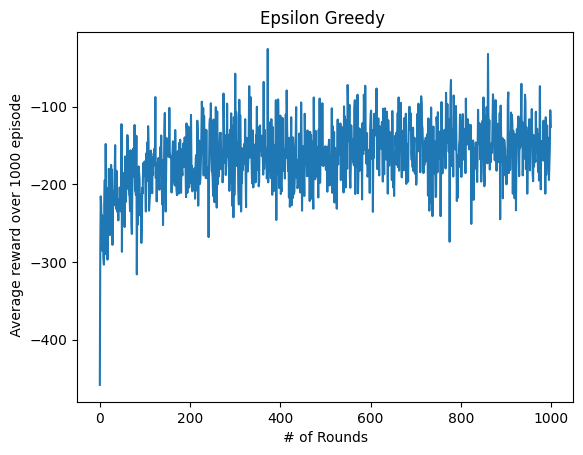

Average payout after 1000 rounds is -163.8035


In [18]:
from blackjackddoriginenv import BlackjackEnv 
import matplotlib.pyplot as plt
import numpy as np 

KEY = {0: 'STAND', 1:'HIT', 2:'DOUBLE DOWN'}

env = BlackjackEnv()
env._reset()

# env = wrappers.Monitor(env, './logs/blackjack-Q', False, True)
import matplotlib.pyplot as plt


num_rounds = 1000 # Payout calculated over every episode
num_episodes = 1000 # num of episodes the simulation will run

agent = Agent(env=env, epsilon= 0.1 , alpha=0.01, gamma= 0.1, num_episodes_to_train = 30000)

total_payout = 0
average_payouts = []


regret = {0:0 , 1:0 , 2:0 }

# PERCENTAGE OF ACTIONS TAKEN
ACTIONSD = {0: 0, 1:0, 2:0}

observation = env._reset()
for sample in range(num_episodes):
    round = 1
    round_payout = 0 # to store total payout over 'num_rounds'
    # Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0
    while round <= num_rounds:
#         print(env.decks)

        action = agent.choose_action(observation,'greedy',False)
#         print(observation)
#         print(action)


    
        next_observation, payout, is_done, _, ddown = env._step(action)
        

    
#         basic_next_observation, basic_payout, basic_is_done, _, basic_ddown = env._step(basic_action)


        
        
#         agent.update_thompson_sampling_action(payout,action)
#         print('OBS: ' + str(observation))
#         print('ACTION: ' + str(KEY[action]))
# #         print('DEALER: ' + str(dealer_up_card))
#         print('OBS2: ' + str(next_observation))
#         print('Payout: ' + str(payout))

#         print('------')
#         if num_episodes > 20:
        ACTIONSD[action] += 1
        agent.learn(observation, action, payout, next_observation)
        round_payout += payout
        observation = next_observation
        if is_done:
            observation = env._reset() # Environment deals new cards to player and dealer
            round += 1
    total_payout += round_payout
    average_payouts.append(round_payout)
# print(agent.Q)
# for x in agent.Q:
# #     if agent.Q[x][2] > 0:
# #         print(x, agent.Q[x])
#     if not x[2]:
#         print(x, agent.Q[x])
print(ACTIONSD)


# Plot payout per 1000 episodes for each value of 'sample'
plt.plot(average_payouts)                
plt.xlabel('# of Rounds')
plt.ylabel(' Average reward over 1000 episode')
plt.title('Epsilon Greedy ')
plt.show()     
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/num_episodes)  )



HELLO
{0: 637196, 1: 741564, 2: 111587}


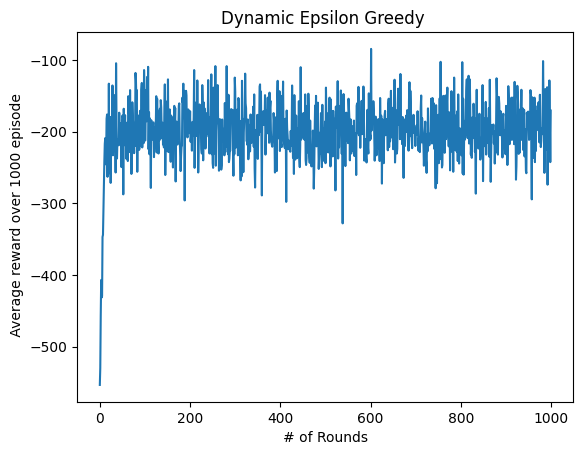

Average payout after 1000 rounds is -199.077


In [27]:
from blackjackddoriginenv import BlackjackEnv 
import matplotlib.pyplot as plt
import numpy as np 

KEY = {0: 'STAND', 1:'HIT', 2:'DOUBLE DOWN'}

env = BlackjackEnv()
env._reset()

# env = wrappers.Monitor(env, './logs/blackjack-Q', False, True)
import matplotlib.pyplot as plt


num_rounds = 1000 # Payout calculated over every episode
num_episodes = 1000 # num of episodes the simulation will run

agent = Agent(env=env, epsilon= 1 , alpha=0.01, gamma= 0.1, num_episodes_to_train = 30000)

total_payout = 0
average_payouts = []

# PERCENTAGE OF ACTIONS TAKEN
ACTIONSD = {0: 0, 1:0, 2:0}



observation = env._reset()
for sample in range(num_episodes):
    round = 1
    round_payout = 0 # to store total payout over 'num_rounds'
    # Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0
    while round <= num_rounds:
#         print(env.decks)

        action = agent.choose_action(observation,'greedy',True)
#         print(observation)
#         print(action)

#         print(sum(player_hand),dealer_up_card)

    
        next_observation, payout, is_done, _, ddown,  = env._step(action)

#         next_observation, payout, is_done, _, ddown = env._step(action)
        
#         agent.update_thompson_sampling_action(payout,action)
#         print('OBS: ' + str(observation))
#         print('ACTION: ' + str(KEY[action]))
# #         print('DEALER: ' + str(dealer_up_card))
#         print('OBS2: ' + str(next_observation))
#         print('Payout: ' + str(payout))

#         print('------')
#         if num_episodes > 20:
        ACTIONSD[action] += 1
        agent.learn(observation, action, payout, next_observation)
        round_payout += payout
        observation = next_observation
        if is_done:
            observation = env._reset() # Environment deals new cards to player and dealer
            round += 1
    total_payout += round_payout
    average_payouts.append(round_payout)
# print(agent.Q)
# for x in agent.Q:
# #     if agent.Q[x][2] > 0:
# #         print(x, agent.Q[x])
#     if not x[2]:
#         print(x, agent.Q[x])
print(ACTIONSD)


# Plot payout per 1000 episodes for each value of 'sample'
plt.plot(average_payouts)                
plt.xlabel('# of Rounds')
plt.ylabel(' Average reward over 1000 episode')
plt.title('Dynamic Epsilon Greedy ')
plt.show()     
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/num_episodes) )


HELLO
{0: 999998, 1: 1, 2: 1}


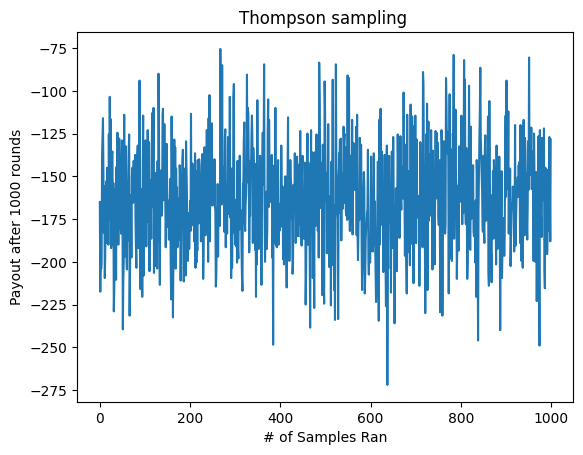

Average payout after 1000 rounds is -163.542


In [36]:
from blackjackddoriginenv import BlackjackEnv 
import matplotlib.pyplot as plt
import numpy as np 

KEY = {0: 'STAND', 1:'HIT', 2:'DOUBLE DOWN'}

env = BlackjackEnv()
env._reset()

# env = wrappers.Monitor(env, './logs/blackjack-Q', False, True)
import matplotlib.pyplot as plt


num_rounds = 1000 # Payout calculated over every episode
num_episodes = 1000 # num of episodes the simulation will run

agent = Agent(env=env, epsilon= 1 , alpha=0.01, gamma= 0.1, num_episodes_to_train = 30000)

total_payout = 0
average_payouts = []

# PERCENTAGE OF ACTIONS TAKEN
ACTIONSD = {0: 0, 1:0, 2:0}

observation = env._reset()
for sample in range(num_episodes):
    round = 1
    round_payout = 0 # to store total payout over 'num_rounds'
    # Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0
    while round <= num_rounds:
#         print(env.decks)

        action = agent.choose_action(observation,'thompson',False)

#         print(action)

    
        next_observation, payout, is_done, _, ddown = env._step(action)
        


#         next_observation, payout, is_done, _, ddown = env._step(action)
    
        agent.update_thompson_sampling_action(payout,action,False)
#         print('OBS: ' + str(observation))
#         print('ACTION: ' + str(KEY[action]))
# #         print('DEALER: ' + str(dealer_up_card))
#         print('OBS2: ' + str(next_observation))
#         print('Payout: ' + str(payout))

#         print('------')
#         if num_episodes > 20:
        ACTIONSD[action] += 1
        agent.learn(observation, action, payout, next_observation)
        round_payout += payout
        observation = next_observation
        if is_done:
            observation = env._reset() # Environment deals new cards to player and dealer
            round += 1
    total_payout += round_payout
    average_payouts.append(round_payout)
# print(agent.Q)
# for x in agent.Q:
# #     if agent.Q[x][2] > 0:
# #         print(x, agent.Q[x])
#     if not x[2]:
#         print(x, agent.Q[x])
print(ACTIONSD)


# Plot payout per 1000 episodes for each value of 'sample'
plt.plot(average_payouts)                
plt.xlabel('# of Samples Ran')
plt.ylabel('Payout after ' + str(num_rounds) + ' rounds')
plt.title('Thompson sampling ')
plt.show()     
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/num_episodes)  )

HELLO
{0: 999998, 1: 1, 2: 1}


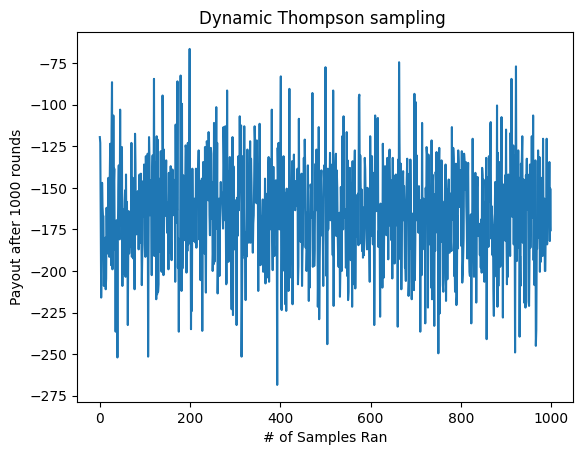

Average payout after 1000 rounds is -165.4535


In [45]:
from blackjackddoriginenv import BlackjackEnv 
import matplotlib.pyplot as plt
import numpy as np 

KEY = {0: 'STAND', 1:'HIT', 2:'DOUBLE DOWN'}

env = BlackjackEnv()
env._reset()

# env = wrappers.Monitor(env, './logs/blackjack-Q', False, True)
import matplotlib.pyplot as plt


num_rounds = 1000 # Payout calculated over every episode
num_episodes = 1000 # num of episodes the simulation will run

agent = Agent(env=env, epsilon= 1 , alpha=0.01, gamma= 0.1, num_episodes_to_train = 30000)

total_payout = 0
average_payouts = []

# PERCENTAGE OF ACTIONS TAKEN
ACTIONSD = {0: 0, 1:0, 2:0}

observation = env._reset()
for sample in range(num_episodes):
    round = 1
    round_payout = 0 # to store total payout over 'num_rounds'
    # Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0
    while round <= num_rounds:
#         print(env.decks)

        action = agent.choose_action(observation,'thompson',True)

#         print(action)


    
        next_observation, payout, is_done, _, ddown,  = env._step(action)
        


#         next_observation, payout, is_done, _, ddown = env._step(action)
        agent.update_thompson_sampling_action(payout,action,True)
#         print('OBS: ' + str(observation))
#         print('ACTION: ' + str(KEY[action]))
# #         print('DEALER: ' + str(dealer_up_card))
#         print('OBS2: ' + str(next_observation))
#         print('Payout: ' + str(payout))

#         print('------')
#         if num_episodes > 20:
        ACTIONSD[action] += 1
        agent.learn(observation, action, payout, next_observation)
        round_payout += payout
        observation = next_observation
        if is_done:
            observation = env._reset() # Environment deals new cards to player and dealer
            round += 1
    total_payout += round_payout
    average_payouts.append(round_payout)
# print(agent.Q)
# for x in agent.Q:
# #     if agent.Q[x][2] > 0:
# #         print(x, agent.Q[x])
#     if not x[2]:
#         print(x, agent.Q[x])
print(ACTIONSD)


# Plot payout per 1000 episodes for each value of 'sample'
plt.plot(average_payouts)                
plt.xlabel('# of Samples Ran')
plt.ylabel('Payout after ' + str(num_rounds) + ' rounds')
plt.title('Dynamic Thompson sampling ')
plt.show()     
print ("Average payout after {} rounds is {}".format(num_rounds,sum(average_payouts)/num_episodes)   )

HELLO
{0: 649408, 1: 612892, 2: 132399}


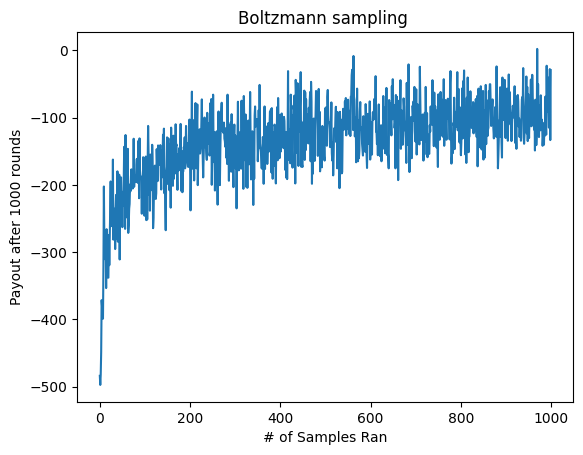

Average payout after 1000 rounds is -133.373


In [54]:
from blackjackddoriginenv import BlackjackEnv 
import matplotlib.pyplot as plt
import numpy as np 

KEY = {0: 'STAND', 1:'HIT', 2:'DOUBLE DOWN'}

env = BlackjackEnv()
env._reset()

# env = wrappers.Monitor(env, './logs/blackjack-Q', False, True)
import matplotlib.pyplot as plt


num_rounds = 1000 # Payout calculated over every episode
num_episodes = 1000 # num of episodes the simulation will run

agent = Agent(env=env, epsilon= 1 , alpha=0.01, gamma= 0.1, num_episodes_to_train = 30000)

total_payout = 0
average_payouts = []

# PERCENTAGE OF ACTIONS TAKEN
ACTIONSD = {0: 0, 1:0, 2:0}

observation = env._reset()
for sample in range(num_episodes):
    round = 1
    round_payout = 0 # to store total payout over 'num_rounds'
    # Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0
    while round <= num_rounds:
#         print(env.decks)

        action = agent.choose_action(observation,'boltzmann',False)

#         print(action)


    
        next_observation, payout, is_done, _, ddown,  = env._step(action)
        



#         next_observation, payout, is_done, _, ddown = env._step(action)
    
#         agent.update_thompson_sampling_action(payout,action,False)
#         print('OBS: ' + str(observation))
#         print('ACTION: ' + str(KEY[action]))
# #         print('DEALER: ' + str(dealer_up_card))
#         print('OBS2: ' + str(next_observation))
#         print('Payout: ' + str(payout))

#         print('------')
#         if num_episodes > 20:
        ACTIONSD[action] += 1
        agent.learn(observation, action, payout, next_observation)
        round_payout += payout
        observation = next_observation
        if is_done:
            observation = env._reset() # Environment deals new cards to player and dealer
            round += 1
    total_payout += round_payout
    average_payouts.append(round_payout)
# print(agent.Q)
# for x in agent.Q:
# #     if agent.Q[x][2] > 0:
# #         print(x, agent.Q[x])
#     if not x[2]:
#         print(x, agent.Q[x])
print(ACTIONSD)


# Plot payout per 1000 episodes for each value of 'sample'
plt.plot(average_payouts)                
plt.xlabel('# of Samples Ran')
plt.ylabel('Payout after ' + str(num_rounds) + ' rounds')
plt.title('Boltzmann sampling ')
plt.show()     
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/num_episodes)   )

HELLO
{0: 651605, 1: 615179, 2: 129542}


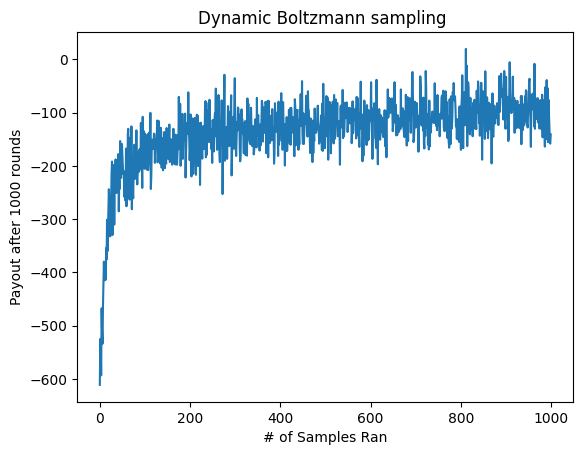

Average payout after 1000 rounds is -134.193


In [63]:
from blackjackddoriginenv import BlackjackEnv 
import matplotlib.pyplot as plt
import numpy as np 

KEY = {0: 'STAND', 1:'HIT', 2:'DOUBLE DOWN'}

env = BlackjackEnv()
env._reset()

# env = wrappers.Monitor(env, './logs/blackjack-Q', False, True)
import matplotlib.pyplot as plt


num_rounds = 1000 # Payout calculated over every episode
num_episodes = 1000 # num of episodes the simulation will run

agent = Agent(env=env, epsilon= 1 , alpha=0.01, gamma= 0.1, num_episodes_to_train = 30000)

total_payout = 0
average_payouts = []

# PERCENTAGE OF ACTIONS TAKEN
ACTIONSD = {0: 0, 1:0, 2:0}

observation = env._reset()
for sample in range(num_episodes):
    round = 1
    round_payout = 0 # to store total payout over 'num_rounds'
    # Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0
    while round <= num_rounds:
#         print(env.decks)

        action = agent.choose_action(observation,'boltzmann',True)

#         print(action)

        next_observation, payout, is_done, _, ddown = env._step(action)
    
#         agent.update_thompson_sampling_action(payout,action,False)
#         print('OBS: ' + str(observation))
#         print('ACTION: ' + str(KEY[action]))
# #         print('DEALER: ' + str(dealer_up_card))
#         print('OBS2: ' + str(next_observation))
#         print('Payout: ' + str(payout))

#         print('------')
#         if num_episodes > 20:
        ACTIONSD[action] += 1
        agent.learn(observation, action, payout, next_observation)
        round_payout += payout
        observation = next_observation
        if is_done:
            observation = env._reset() # Environment deals new cards to player and dealer
            round += 1
    total_payout += round_payout
    average_payouts.append(round_payout)
# print(agent.Q)
# for x in agent.Q:
# #     if agent.Q[x][2] > 0:
# #         print(x, agent.Q[x])
#     if not x[2]:
#         print(x, agent.Q[x])
print(ACTIONSD)


# Plot payout per 1000 episodes for each value of 'sample'
plt.plot(average_payouts)                
plt.xlabel('# of Samples Ran')
plt.ylabel('Payout after ' + str(num_rounds) + ' rounds')
plt.title('Dynamic Boltzmann sampling ')
plt.show()     
print ("Average payout after {} rounds is {}".format(num_rounds,  sum(average_payouts)/num_episodes)  )

553.5235


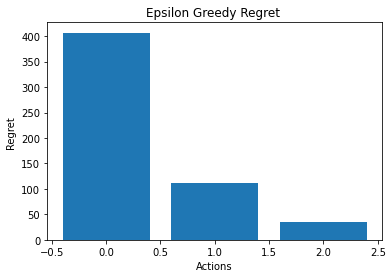

In [56]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt

data = [406.8425,  111.9255 , 34.7555]
plt.bar([0,1,2], data)

print(sum(data))

plt.xlabel('Actions')
plt.ylabel('Regret ' )
plt.title('Epsilon Greedy Regret ')

plt.show()

282.1715


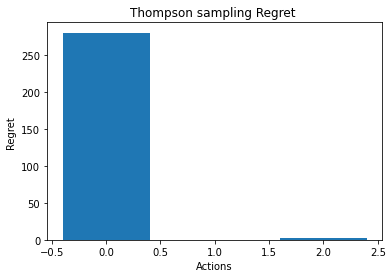

In [57]:
data = [280.1715, 0 , 2]
plt.bar([0,1,2], data)

print(sum(data))
plt.xlabel('Actions')
plt.ylabel('Regret ' )
plt.title('Thompson sampling Regret ')

plt.show()

523.3710000000001


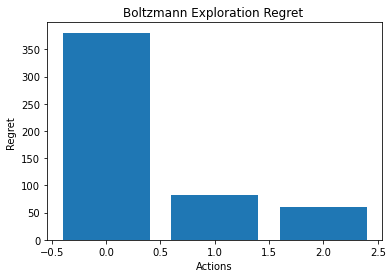

In [58]:
data = [380.5855, 81.7685 , 61.0170]
plt.bar([0,1,2], data)

print(sum(data))
plt.xlabel('Actions')
plt.ylabel('Regret ' )
plt.title('Boltzmann Exploration Regret ')

plt.show()